## Matching - Smoking data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalinference import CausalModel

### Reading and cleaning - smoking data

We will perform the same cleaning procedure proposed by Vincent D. Warmerdam.

Source: https://calmcode.io/smoking/cleaning.html

In [2]:
df = pd.read_csv('https://calmcode.io/datasets/smoking.csv')

In [3]:
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [4]:
def clean_dataframe(dataf):
    return (dataf
            .assign(alive=lambda d: (d['outcome'] == 'Alive').astype(np.int))
            .assign(smokes=lambda d: (d['smoker'] == 'Yes').astype(np.int)))

clean_df = df.pipe(clean_dataframe)

In [5]:
clean_df.head()

,outcome,smoker,age,alive,smokes
0,Alive,Yes,23,1,1
1,Alive,Yes,18,1,1
2,Dead,Yes,71,0,1
3,Alive,No,67,1,0
4,Alive,No,64,1,0


### Framing the problem

By analyzing the data, the proportion of individuals that survive in the smokers versus non smokers groups are the following:

In [6]:
clean_df.groupby("smokes").agg({'alive': np.mean})

,alive
smokes,
0,0.685792
1,0.761168


76% of the smokers survive versus 68% of the non smokers. So, smoking is good for us? Strange, isn't it?

Probably might be a good idea to control our results by age. Let's check the age of both groups:

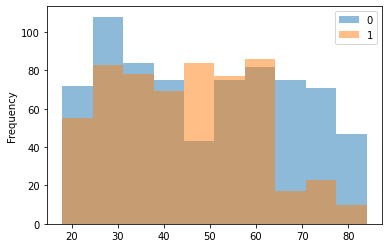

In [7]:
clean_df.groupby("smokes")['age'].plot(kind='hist', alpha=0.5, legend=True);

In [8]:
clean_df.groupby("smokes").agg({'alive': np.mean, 'age': [np.mean, np.std]})

alive        age           
            mean       mean        std
smokes                                
0       0.685792  48.699454  18.793713
1       0.761168  44.682131  15.275113

Hum... the two groups are not comparable when it comes to age. The non smokers group contains older individuals.

How can we estimate the effect of smoking in people survival through time?

### Smokers versus non smokers - via Matching

Source: https://matheusfacure.github.io/python-causality-handbook/10-Matching.html

In [20]:
# Creating a causal model
cm = CausalModel(
    # Target - if individual is alive
    Y=clean_df["alive"].values, 
    
    # Treatment variable - smoker or non smoker
    D=clean_df["smokes"].values, 
    
    # Confounder - age variable
    X=clean_df["age"].values
)

In [21]:
# Estimate via matching
# Nearest neighbor match comparing treated x untreated with bias adjustment
cm.est_via_matching(matches=1, bias_adj=True)

# Printing estimates and Average treatment effect
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.039      0.021     -1.897      0.058     -0.080      0.001
           ATC     -0.040      0.024     -1.680      0.093     -0.086      0.007
           ATT     -0.039      0.021     -1.896      0.058     -0.079      0.001

